# CSNAnalysis Tutorial
### A brief introduction to the use of the CSNAnalysis package
---
**Updated Aug 19, 2020**
*Dickson Lab, Michigan State University*

## Overview

The CSNAnalysis package is a set of tools for network-based analysis of molecular dynamics trajectories.
  CSNAnalysis is an easy interface between enhanced sampling algorithms
  (e.g. WExplore implemented in `wepy`), molecular clustering programs (e.g. `MSMBuilder`), graph analysis packages (e.g. `networkX`) and graph visualization programs (e.g. `Gephi`).

### What are conformation space networks?

A conformation space network is a visualization of a free energy landscape, where each node is a cluster of molecular conformations, and the edges show which conformations can directly interconvert during a molecular dynamics simulation. A CSN can be thought of as a visual representation of a transition matrix, where the nodes represent the row / column indices and the edges show the off-diagonal elements. `CSNAnalysis` offers a concise set of tools for the creation, analysis and visualization of CSNs.

**This tutorial will give quick examples for the following use cases:**

1. Initializing CSN objects from count matrices
2. Trimming CSNs
2. Obtaining steady-state weights from a transition matrix
  * By eigenvalue
  * By iterative multiplication
3. Computing committor probabilities to an arbitrary set of basins
4. Exporting gexf files for visualization with the Gephi program

## Getting started

Clone the CSNAnalysis repository:

```
git clone https://github.com/ADicksonLab/CSNAnalysis.git```

Navigate to the examples directory and install using pip:

```
cd CSNAnalysis
pip install --user -e
```

Go to the examples directory and open this notebook (`examples.ipynb`):

```
cd examples; jupyter notebook```

## Dependencies

I highly recommend using Anaconda and working in a `python3` environment. CSNAnalysis uses the packages `numpy`, `scipy` and `networkx`.  If these are installed then the following lines of code should run without error:

In [1]:
import numpy as np
import networkx as nx
import scipy

If `CSNAnalysis` was installed (i.e. added to your `sys.path`), then this should also work:

In [2]:
from csnanalysis.csn import CSN
from csnanalysis.matrix import *

This notebook also uses `matplotlib`, to visualize output.

In [3]:
import matplotlib

Great!  Now let's load in the count matrix that we'll use for all the examples here:

In [4]:
count_mat = scipy.sparse.load_npz('matrix.npz')

## Background: Sparse matrices

It's worth knowing a little about sparse matrices before we start. If we have a huge $N$ by $N$ matrix, where $N > 1000$, but most of the elements are zero, it is more efficient to store the data as a sparse matrix.

In [5]:
type(count_mat)

scipy.sparse.coo.coo_matrix

`coo_matrix` refers to "coordinate format", where the matrix is essentially a set of lists of matrix "coordinates" (rows, columns) and data:

In [6]:
rows = count_mat.row
cols = count_mat.col
data = count_mat.data

for r,c,d in zip(rows[0:10],cols[0:10],data[0:10]):
    print(r,c,d)

0 0 382.0
0 651 2.0
0 909 2.0
0 920 2.0
0 1363 1.0
0 1445 2.0
0 2021 5.0
0 2022 7.0
0 2085 4.0
0 2131 1.0


Although it can be treated like a normal matrix ($4000$ by $4000$ in this case):

In [7]:
count_mat.shape

(4000, 4000)

It only needs to store non-zero elements, which are much fewer than $4000^2$:

In [8]:
len(rows)

44163

**OK, let's get started building a Conformation Space Network!**

---

## 1) Initializing CSN objects from count matrices

To get started we need a count matrix, which can be a `numpy` array, or a `scipy.sparse` matrix, or a list of lists:

In [9]:
our_csn = CSN(count_mat,symmetrize=True)

Any of the `CSNAnalysis` functions can be queried using "?"

In [10]:
CSN?

The `our_csn` object now holds three different representations of our data.  The original counts can now be found in `scipy.sparse` format:

In [11]:
our_csn.countmat

<4000x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 62280 stored elements in COOrdinate format>

A transition matrix has been computed from this count matrix according to: 
\begin{equation}
t_{ij} = \frac{c_{ij}}{\sum_j c_{ij}}
\end{equation}

In [12]:
our_csn.transmat

<4000x4000 sparse matrix of type '<class 'numpy.float64'>'
	with 62280 stored elements in COOrdinate format>

where the elements in each column sum to one:

In [13]:
our_csn.transmat.sum(axis=0)

matrix([[1., 1., 1., ..., 1., 1., 1.]])

Lastly, the data has been stored in a `networkx` directed graph:

In [14]:
our_csn.graph

that holds the nodes and edges of our csn, and we can use in other `networkx` functions.  For example, we can calculate the shortest path between nodes 0 and 10:

In [15]:
nx.shortest_path(our_csn.graph,0,10)

[0, 1445, 2125, 2043, 247, 1780, 10]

---
## 2) Trimming CSNs

A big benefit of coupling the count matrix, transition matrix and graph representations is that elements can be "trimmed" from all three simultaneously.  The `trim` function will eliminate nodes that are not connected to the main component (by inflow, outflow, or both), and can also eliminate nodes that do not meet a minimum count requirement:

In [16]:
our_csn.trim(by_inflow=True, by_outflow=True, min_count=20)

The trimmed graph, count matrix and transition matrix are stored as `our_csn.trim_graph`, `our_csn.trim_countmat` and `our_csn.trim_transmat`, respectively.

In [17]:
our_csn.trim_graph.number_of_nodes()

2282

In [18]:
our_csn.trim_countmat.shape

(2282, 2282)

In [19]:
our_csn.trim_transmat.shape

(2282, 2282)

## 3) Obtaining steady-state weights from the transition matrix

Now that we've ensured that our transition matrix is fully-connected, we can compute its equilibrium weights.  This is implemented in two ways.

First, we can compute the eigenvector of the transition matrix with eigenvalue one:

In [20]:
wt_eig = our_csn.calc_eig_weights()

This can exhibit some instability, especially for low-weight states, so we can also calculate weights by iterative multiplication of the transition matrix, which can take a little longer:

In [21]:
wt_mult = our_csn.calc_mult_weights()

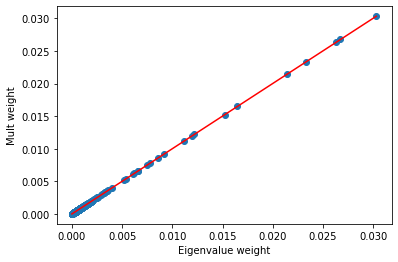

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(wt_eig,wt_mult)
plt.plot([0,wt_mult.max()],[0,wt_mult.max()],'r-')
plt.xlabel("Eigenvalue weight")
plt.ylabel("Mult weight")
plt.show()

These weights are automatically added as attributes to the nodes in `our_csn.graph`:

In [23]:
our_csn.graph.node[0]

{'label': 0,
 'count': 482,
 'trim': 0.0,
 'eig_weights': 0.002595528367725156,
 'mult_weights': 0.0025955283677248217}

## 4) Committor probabilities to an arbitrary set of basins

We are often doing simulations in the presence of one or more high probability "basins" of attraction.  When there more than one basin, it can be useful to find the probability that a simulation started in a given state will visit (or "commit to") a given basin before the others.

`CSNAnalysis` calculates committor probabilities by creating a sink matrix ($S$), where each column in the transition matrix that corresponds to a sink state is replaced by an identity vector. This turns each state into a "black hole" where probability can get in, but not out.  

By iteratively multiplying this matrix by itself, we can approximate $S^\infty$.  The elements of this matrix reveal the probability of transitioning to any of the sink states, upon starting in any non-sink state, $i$.

Let's see this in action.  We'll start by reading in a set of three basins:  $A$, $B$ and $U$.

In [24]:
Astates = [2031,596,1923,3223,2715]
Bstates = [1550,3168,476,1616,2590]
Ustates = list(np.loadtxt('state_U.dat',dtype=int))

We can then use the `calc_committors` function to calculate committors between this set of three basins. This will calculate $p_A$, $p_B$, and $p_U$ for each state, which sum to one.

In [25]:
basins = [Astates,Bstates,Ustates]
labels = ['pA','pB','pU']
comms = our_csn.calc_committors(basins,labels=labels)

The committors can be interpreted as follows:

In [27]:
i = our_csn.trim_indices[0]
print('comms['+str(i)+'] = ',comms[i])
print('\nIn other words, if you start in state {0:d}:'.format(i))
print('You will reach basin A first with probability {0:.2f}, basin B with probability {1:.2f} and basin U with probability {2:.2f}'.format(comms[i,0],comms[i,1],comms[i,2]))

comms[0] =  [0.26406217 0.29477873 0.44115911]

In other words, if you start in state 0:
You will reach basin A first with probability 0.26, basin B with probability 0.29 and basin U with probability 0.44


## 5) Exporting graph for visualization in Gephi

`NetworkX` is great for doing graph-based analyses, but not stellar at greating graph layouts for large(r) networks. However, they do have excellent built-in support for exporting graph objects in a variety of formats. 

Here we'll use the `.gexf` format to save our network, as well as all of the attributes we've calculated, to a file that can be read into [Gephi](https://gephi.org/), a powerful graph visualization program.  While support for Gephi has been spotty in the recent past, it is still one of the best available options for graph visualization.

Before exporting to `.gexf`, let's use the committors we've calculated to add colors to the nodes:

In [28]:
rgb = our_csn.colors_from_committors(comms)
our_csn.set_colors(rgb)

Now we have added some properties to our nodes under 'viz', which will be interpreted by Gephi:

In [29]:
our_csn.graph.node[0]

{'label': 0,
 'count': 482,
 'trim': 0.0,
 'eig_weights': 0.002595528367725156,
 'mult_weights': 0.0025955283677248217,
 'pA': 0.26406216543613925,
 'pB': 0.2947787254045238,
 'pU': 0.4411591091593356,
 'viz': {'color': {'r': 152, 'g': 170, 'b': 255, 'a': 0}}}

And we can use an internal `networkx` function to write all of this to a `.gexf` file:

In [30]:
nx.readwrite.gexf.write_gexf(our_csn.graph.to_undirected(),'test.gexf')

After opening this file in Gephi, I recommend creating a layout using the "Force Atlas 2" algorithm in the layout panel.  I set the node sizes to the "eig_weights" variable, and after exporting to pdf and adding some labels, I get the following:

![Gephi graph export](committor_net_3state.png)

**That's the end of our tutorial!**  I hope you enjoyed it and you find `CSNAnalysis` useful in your research.  If you are having difficulties with the installation or running of the software, feel free to create an [issue on the Github page](https://github.com/ADicksonLab/CSNAnalysis).